# Yeast cells detection sample notebook

In [1]:
import sys
sys.path.append('../')
#sys.path.append('%HOMEPATH%/detectron2') #insert local path to detecron2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yeastcells.clustering as clustering
import yeastcells.features as features
import yeastcells.data as data
import yeastcells.model as model
import yeastcells.output as output
import yeastcells.visualize as visualize

%matplotlib notebook

In [2]:
cd ~

/home/p301081


### Load data

In [3]:
path = '../../slow-data/yeastcells/data/DATA_CIT/Test_Images'
filenames = data.load_data(path, ff = '.tif')
print(filenames)

['../../slow-data/yeastcells/data/DATA_CIT/Test_Images/Movie_test1.tif']


In [4]:
fn = filenames[0]
image = data.read_image(fn, single_im = False, shape=2)
np.shape(image) #(frames, length, width, channels)

(300, 512, 512, 3)

In [5]:
image = image[39:]
len(image)

261

### Load and run model on data for segmentation

In [6]:
#set path to model_final.pth
model_path = '/var/tensorflow-logs/p253591/yeast-cell-detection-run-4'

#load model
predictor = model.load_model(model_path, seg_thresh=0.94, device='cuda:0') #set GPU if available otherwise use 'cpu'

In [7]:
output = [
  {'instances': predictor(frame)['instances'].to('cpu')}
  for frame in image
]

/home/p301081/.virtualenvs/yeastcells/lib/python3.7/site-packages/detectron2/layers/wrappers.py:226: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  return x.nonzero().unbind(1)


### Run clustering algorithm for tracking

In [8]:
labels, coordinates = clustering.cluster_cells(output, dmax=5, min_samples=5, eps=0.6, progress=False) #for time-series
#labels, coordinates = get_instance_numbers(output) #for single image

/home/p301081/.virtualenvs/yeastcells/lib/python3.7/site-packages/sklearn/neighbors/_base.py:168: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  EfficiencyWarning)


In [17]:
#plot paths
ax = visualize.plot_paths(
  labels,
  coordinates[:, [2,1,0]],
  style={'linewidth': 1},
  xlim=(0, 512),
  ylim=(0, 512),
  title='',
)

<IPython.core.display.Javascript object>

### Extract features and visualize tracking and segmentation

In [10]:
s, t = features.get_seg_track(labels, output, frame = None) # total

The number of segmentations is 16125
The number of tracked cells is 431


In [11]:
s, t = features.get_seg_track(labels, output, frame = 0, start=40) # by frame

The number of segmentations in frame 40 is 93
The number of tracked cells in frame 40 is 66


In [12]:
features.track_len(labels, label=0) #select a label to extract the length of its track

255

In [13]:
contours = features.extract_contours(output) 

In [16]:
scene = visualize.create_scene(image, output, labels, contours, thickness=1, color=[255,0,255], framenum=True, labelnum=True)
movie = visualize.show_animation(scene, title='', delay=100) 

<IPython.core.display.Javascript object>

In [15]:
scene = visualize.create_scene(image, output, labels, contours, thickness=1, color=None, framenum=True, labelnum=True)
cell_scene, label = visualize.select_cell(scene, coordinates, labels, w=60, l=0) # choose image window (w) and label (l)
movie = visualize.show_animation(cell_scene, title='', delay=100)

<IPython.core.display.Javascript object>

In [18]:
polygons_clust =  features.polygons_per_cluster(labels, contours, output)

<IPython.core.display.Javascript object>


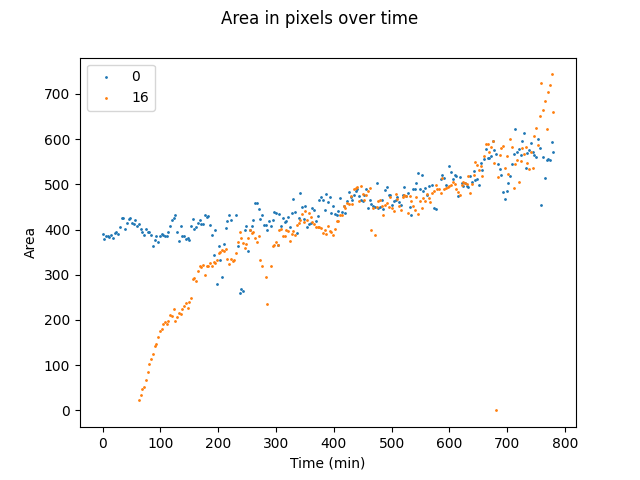

../yeastcells/visualize.py:129: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


In [19]:
ax = visualize.plot_area_profiles(polygons_clust, ti=3, label_list=[0,16], ax=None, title="Area in pixels over time")

### Output

In [20]:
_, _, pred_df = data.get_pred(output, labels, coordinates, ti=3, start=40)
polygons_inst =  features.polygons_per_instance(labels, contours, output)
pred_df = features.add_area_df(polygons_inst, labels, pred_df, start=40)

In [ ]:
pred_df.head(20)

In [21]:
masks = features.get_masks(output)

In [23]:
visualize.plot_polygon_mask(
    masks, labels, output, image, polygons_clust, 
    label_list=[0,1,2,3,4,5,6,7,9,10], frame=0, ax=None, title=None
)

<IPython.core.display.Javascript object>

In [ ]:
agr = features.get_average_growth_rate(polygons_clust, labels, output)
area_std = features.get_area_std(polygons_clust, labels, pred_df)
position_std = features.get_position_std(polygons_clust, labels, pred_df)

In [ ]:
features_df = pd.Dataframe(agr, columns=['Cell_label', 'Average Growth Rate'])
features_df['Std Area(pxl)'] = area_std
features_df['Std Position'] = position_std

In [ ]:
features_df.head(20)